<a href="https://colab.research.google.com/github/Rh-RAP/Energy_demand/blob/main/Rhuana_Reis_Proyecto_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumen Ejectivo 💼

El presente proyecto tiene como objetivo la creación de un modelo capaz de predicir la demanda díaria de energia en el mercado eletrico español, afin de garantizar una mejor evaluación del consumo y proporcionar un mejor entendimento del mercado en que ElectroStock S.A⚡️está insertado.<br>
Para esó se usó una série temporal con el histórico de consumo médio en España de 2015 hasta 2018, tambiem incluí informaciones que consideré relevantes para la mejoria del poder de predicíon del modelo, una de ellas es los días festivos en el país, que despúes de las análisis se notó que en general hay una baja del consumo en estos días. Otra relación que se pudo sacar de los datos es que hay una relación expresiva entre los días de la semana y la media de consumo de energia.<br>
Antes de llegar al modelo que os apresento, he trabajado con otros dos modelos que tenian caracteristicas distintas entre si, pero entre todos el modelo que presentó mejor capacidad de predicíon es el de XGboost, que tiene en cuenta principalmente el consumo del día anterior y el consumo del día de la semana anterior, apresentanto solamente un error de predición de 5% para mas o menos. <br>
Entonces mi sugerencia es la implementación por la empresa del modelo de XGboost para la predición del consumo.


# Informe de Negocio 📊

Para la elaboracíon del modelo se hizo una análisis profundo del comportamiento del consumo de energia en España con el tiempo.



###  Analisis Descriptivo<br>
La serie temporal con que trabajé tenia datos del consumo horario medio de energia en España de 2015 hasta 2018. Como el horizonte en el cual se pretende hacer la previsión en el diário, sumé los datos de las horas de cada día, así me quedé con el consumo médio diário.<br>
Con el analisis fue posible sacar la conclusion de que la cantidad de KW consumido diariamente tiene una relacion con la temporalidad, o sea se trata de una série estacionária, a depender el día de la semana que es o dela epoca del año ese consumo se eleva o disminuye.
Otra caracteristica importante es que la serie tiene tendencia mutiplicativa, pues el consumo de energia por parte de los españoles está creciento con el pasar del tiempo. Como es posible ver en la gráfica abajo.

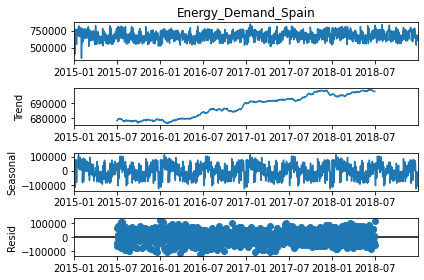

In [ ]:
result = seasonal_decompose(df['Energy_Demand_Spain'], period = 365)
result
result.plot()
pyplot.show()

El consumo médio de España está entre los 500kw y 800kw diarios <br>
Al analizar el consumo en los días de festivo es posible ver que en general hay una disminuida el la media de consumo, con excepción de el 01 de enero donde hay un aumento del consumo.



Despues de analizar y comprender el comportamineto de nuestra variable principal( el consumo), selecioné las caracteristicas temporales que creí serian indispensables para una buena predición. El modelo presentado tiene en cuenta todas esas variables, que son: Los dias de la semana, el consumo del dia anterior y los días festivos.

### Comparacion resultados de Modelo

El modelo usa como variables principales el consumo médio del dia anterior y el de la semana anterior, que segundo analizado son las caracteristicas que más influen en el consumo del dia posterior.El modelo tambíen tiene en consideración el trimestre, donde es posible notar el cambio de temperatura <br>
Como se puede ver en la gráfica abajo, las variables que más explican el consumo futuro de energia son: del día anterior y el dia de la semana anterior, logo abajo el lag_4 que representa los trimestres.


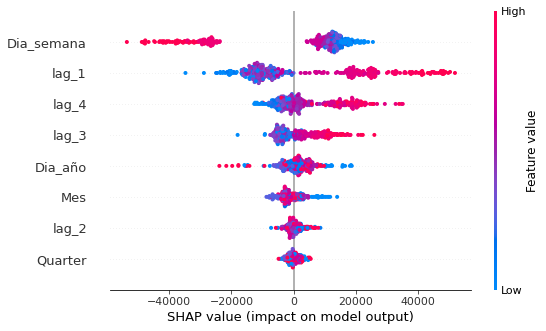

In [ ]:
import shap
explainer = shap.TreeExplainer(m_b)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

Com eso los resultados conseguidos fueron estos, apresentados en la grafica abajo:

In [ ]:
px.line(df_b, y = [ 'Energy_Demand_Spain', 'Energia_pred'], line_dash = 'type')

El modelo tiene un error médio de 5.2% para mas o menos, en la predicción:

In [ ]:
df_error_boosting

,Train,Test
MAPE,0.046322,0.052066
MAE,30812.962325,35568.972141


### Mejorias

Para un proyecto con más tiempo y más recursos de procesamiento yo agregaria la variable de temperatura y separaria los datos por comunidades altonomas y zonas. Con eso creo que la capacidad de predición del modelo mejorara.

# Reporte Científico 👩🏻‍💻

### Import de librerias

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
from prophet import Prophet
import plotly.express as px
import datetime as dt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount('/content/drive')
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt
from sklearn.linear_model import LinearRegression
import itertools
from catboost import CatBoostRegressor


Mounted at /content/drive


### Preparacion dela Base de datos

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy_demand_spain_utc.csv')

In [ ]:
df.head()

,Datetime,Energy_Demand_Spain
0,2014-12-31 23:00:00+00:00,25385.0
1,2015-01-01 00:00:00+00:00,24382.0
2,2015-01-01 01:00:00+00:00,22734.0
3,2015-01-01 02:00:00+00:00,21286.0
4,2015-01-01 03:00:00+00:00,20264.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datetime             35064 non-null  object 
 1   Energy_Demand_Spain  35028 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB


In [ ]:
df['Datetime']= pd.to_datetime(df['Datetime']) #cambio del dtype para datetime
df.head(5)

,Datetime,Energy_Demand_Spain
0,2014-12-31 23:00:00+00:00,25385.0
1,2015-01-01 00:00:00+00:00,24382.0
2,2015-01-01 01:00:00+00:00,22734.0
3,2015-01-01 02:00:00+00:00,21286.0
4,2015-01-01 03:00:00+00:00,20264.0


In [ ]:
df.set_index('Datetime', inplace= True)

In [ ]:
df= df.tz_convert('Europe/Madrid') # cambio del timezone



In [ ]:
df = df.reset_index()



In [ ]:
df.head()

,Datetime,Energy_Demand_Spain
0,2015-01-01 00:00:00+01:00,25385.0
1,2015-01-01 01:00:00+01:00,24382.0
2,2015-01-01 02:00:00+01:00,22734.0
3,2015-01-01 03:00:00+01:00,21286.0
4,2015-01-01 04:00:00+01:00,20264.0


In [ ]:
df = df.resample('D', on='Datetime').sum() #bajando para la frequencia diaria


In [ ]:
df.head()

,Energy_Demand_Spain
Datetime,
2015-01-01 00:00:00+01:00,573522.0
2015-01-02 00:00:00+01:00,654031.0
2015-01-03 00:00:00+01:00,602656.0
2015-01-04 00:00:00+01:00,650703.0
2015-01-05 00:00:00+01:00,406070.0


# Lectura de los datos

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Energy_Demand_Spain,1461.0,688019.44627,66962.050627,342907.0,650218.0,687445.0,739216.0,847564.0


In [ ]:
df = df.reset_index()

In [ ]:
px.line(df, x = 'Datetime', y = 'Energy_Demand_Spain')

- Hay algunos puntos en 2015 que parecem ser outliner, pues eston muy abajo de los otros valores de consumo.

In [ ]:
px.histogram(df['Energy_Demand_Spain'])

- Con el histogran es pocible veer que el consumo de energia tiene una distribuicion relativamente normal y gran parte de la data está entre 500k y 800k. Hay dos puntos con 0 y 400k que estan muy abajo de los demais. Ire analizarlos con más profundidad

In [ ]:
df = df.set_index(['Datetime'])

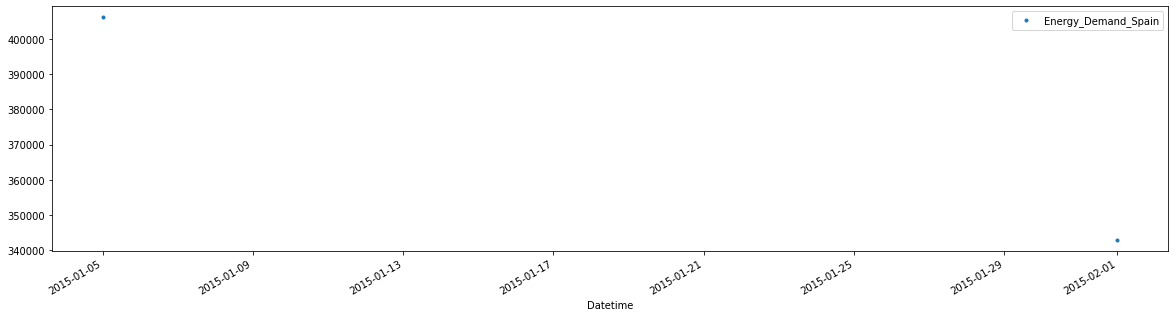

In [ ]:
df.query('Energy_Demand_Spain < 500000').plot(figsize=(20,5), style = '.')

-Es posible notar que son dos dias donde el consumo esta abajo de la média, que me parecen casos puntuales que puede disminuir la capacidad de generalización del modelo. Por eso los voy eliminar.

In [ ]:
df = df.query('Energy_Demand_Spain >= 500000').copy()

In [ ]:
px.line(df, y = 'Energy_Demand_Spain')

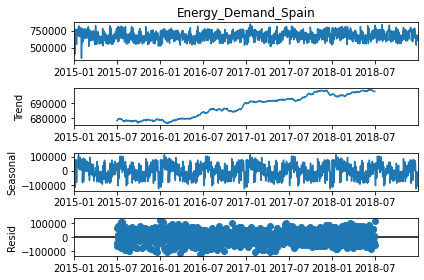

In [ ]:
result = seasonal_decompose(df['Energy_Demand_Spain'], period = 365)
result
result.plot()
pyplot.show()

- Con el periodo de 365 días se nota claramente que el consumo de energia tiene tendencia crescente y que es seasonal(hay meses de màs consumo)

In [ ]:
df_corr = df['Energy_Demand_Spain'].autocorr()
df_corr

0.3736721695460922

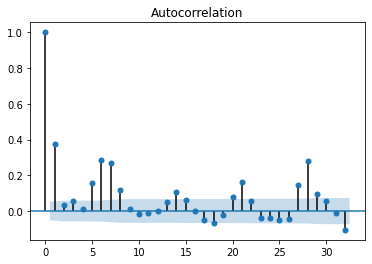

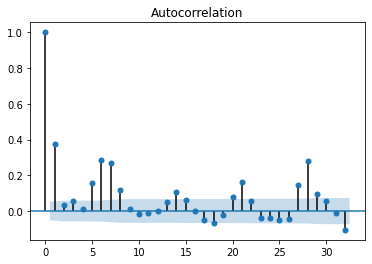

In [ ]:
plot_acf(df['Energy_Demand_Spain'])

- Con la autocorrelacion es posible inferir que los dias de la semana tiene una relacion más grande entre si, quer decir, el punto 14 tiene maior relacion con el punto 21 que con el punto 18. O sea los lunes se parece más entre si que con un domingo, que seria el punto más cercano a el.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result= adfuller(df)
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -6.390127987038591,
 'pvalue': 2.1160029121779533e-08,
 'usedlag': 21,
 'nobs': 1437,
 'criticalvalues': {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 'icbest': 35483.311548035694}

{'adf': -6.390127987038591,
 'pvalue': 2.1160029121779533e-08,
 'usedlag': 21,
 'nobs': 1437,
 'criticalvalues': {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 'icbest': 35483.311548035694}

In [ ]:
result = adfuller(df['Energy_Demand_Spain'])
print('p-value: %f' % result[1])

p-value: 0.000000


- p-value = 0.000, eso confirma que la serie es estacionaria y que tiene alguna estructura dependiente del tiempo.

In [ ]:
df = df.reset_index()

In [ ]:
df= df.rename(columns = {'Datetime': 'ds', 'Energy_Demand_Spain': 'y'})
df['ds']= df['ds'].dt.tz_localize(None)

- División del df en train y test

In [ ]:
df['type'] = 'No'
df.loc[:1095, 'type'] = 'train' # El train va hacer de 3 años(alrededor de 80%) y el test de uno
df.loc[1096:, 'type'] = 'test'
df_train = df.loc[:1095]
df_test = df.loc[1095:]

In [ ]:
"""fig, ax = plt.subplots(figsize= (15,5)) #Hice un plot de la división de train y test
df_train.plot(ax=ax, label = 'Training Set', title = 'División Train/Test')
df_test.plot(ax=ax, label = 'Test Set')
plt.show()"""

"fig, ax = plt.subplots(figsize= (15,5)) #Hice un plot de la división de train y test\ndf_train.plot(ax=ax, label = 'Training Set', title = 'División Train/Test')\ndf_test.plot(ax=ax, label = 'Test Set')\nplt.show()"

# Prophet

### Cross Validation

- Voy hacer un "for loop" para determinar los mejores hiperparametros para el modelo, iré selecionar los que apresentem el MAE (media del error absoluto) más pequeño. Para eso usaré cross validation con todo en dataset , con el horizonte de un día(que és el horizonte de prevision solicitado), con el period de 7 días y initial de 2 años. - He probado diferentes combinaciones y entre 2 y 3 años los hiperparametros no cambiaron solo el MAE disminuiu, entonces elegí quedarme con 2 años por tempo de procesamiento.

In [ ]:
param_grid = {'changepoint_prior_scale': [0.001, 0.1, 0.5],
              'seasonality_prior_scale': [10.0, 0.1, 1.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generar todas las combinaciones de  parametros
all_params = [dict(zip(param_grid.keys(), v))
             for v in itertools.product(*param_grid.values())]
maes = [] #guardar todos los valores de los MAES
counter = 1

# ir sobre todos los parametros
for params in all_params:
  m_cv = Prophet( **params) # crear el modelo
  print(counter)
  counter = counter + 1
  m_cv.fit(df)# 'fitear' el modelo com todos los parametros

  # cross validate the model
  df_cv = cross_validation(m_cv,
                             horizon="1 day",
                             period= " 7 days",
                             initial="730 days")
  df_p_m = performance_metrics(df_cv)
  # sacar los MAES y adicionar en la lista
  maes.append(df_p_m['mae'].values[0])


In [ ]:
parametros = pd.DataFrame(all_params)
parametros['MAE'] = maes
mejor_parametro = all_params[np.argmin(maes)]
print(mejor_parametro)
parametros.sort_values(by='MAE').iloc[0]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


changepoint_prior_scale               0.1
seasonality_prior_scale               0.1
seasonality_mode           multiplicative
MAE                          39917.408793
Name: 9, dtype: object

Como es posible veer los parametros con el mejor resultaldo del MAE(39917.408793) son {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, y seron ellos usados para el modelo

### Festivos

In [ ]:
import holidays
spain_holidays = holidays.Spain(years=[2015,2016,2017,2018])
df_spain_holidays = pd.DataFrame([spain_holidays], index=['holiday'])
df_spain_hday= df_spain_holidays.transpose()
df_spain_hday=df_spain_hday.reset_index()
df_spain_hday = df_spain_hday.rename(columns = {'index': 'ds'})
df_spain_hday['ds'] = pd.to_datetime(df_spain_hday['ds'])
df_spain_hday

,ds,holiday
0,2016-01-01,Año nuevo
1,2016-01-06,Epifanía del Señor
2,2016-03-24,Jueves Santo
3,2016-03-25,Viernes Santo
4,2016-05-02,Día del Trabajador (Trasladado)
5,2016-08-15,Asunción de la Virgen
6,2016-10-12,Día de la Hispanidad
7,2016-11-01,Todos los Santos
8,2016-12-06,Día de la Constitución Española
9,2016-12-08,La Inmaculada Concepción


### Entrenando el Modelo

In [ ]:
df_train

,ds,y,type
0,2015-01-01,573522.0,train
1,2015-01-02,654031.0,train
2,2015-01-03,602656.0,train
3,2015-01-04,650703.0,train
4,2015-01-06,667264.0,train
...,...,...,...
1091,2017-12-29,676115.0,train
1092,2017-12-30,616537.0,train
1093,2017-12-31,580885.0,train
1094,2018-01-01,539088.0,train


In [ ]:
m = Prophet(holidays = df_spain_hday,
            changepoint_prior_scale= 0.1,
            seasonality_prior_scale= 0.1,
            seasonality_mode= 'multiplicative').fit(df_train)

df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '1 day')

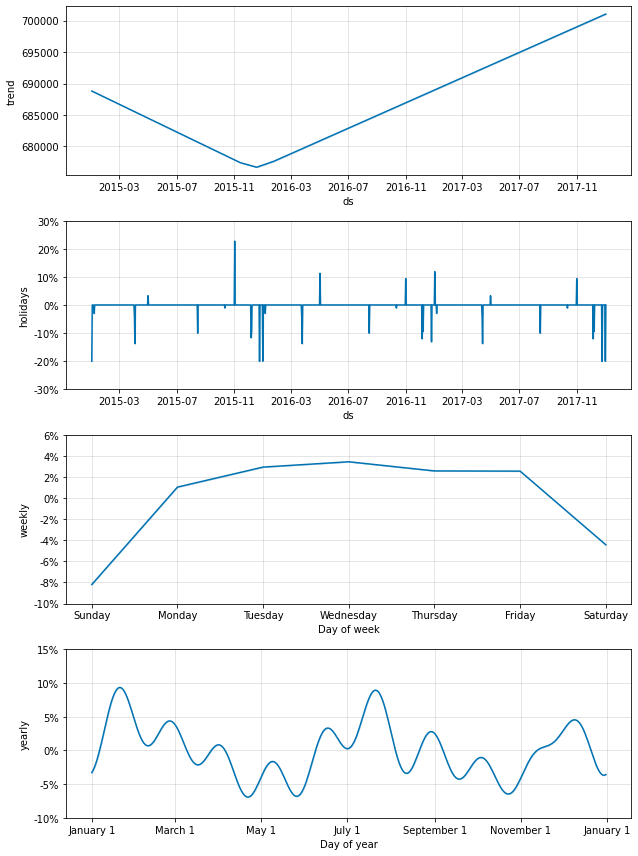

In [ ]:
forecast_train=m.predict(df_train)
forecast_test = m.predict(df_test)
fig = m.plot_components(forecast_train)

Con las gráficas es posible inferir que:
- La tendencia del  consumuso de energia sigue en crescimento linear.
- Con holidays se nota que en grande parte de los dias festivos el consumo de energia disminui.
- La frecuencia semanal confirma el esperado, que el consumo disminui en el final de semana.
- En la estacionalidad se nota que el consumo de energia llega a sus puntos más elevados en los periodos de temperaturas extremas(invierno/ verano) y en los meses de primevera y otoño que no hace nin tanto frio ni tanto calor el consumo baja.


## Metricas de error

In [ ]:
MAPE_metric = pd.DataFrame(index=['MAPE'],
                           data={'Train': [mean_absolute_percentage_error(df_train['y'], forecast_train['yhat'])],
                                 'Test': [mean_absolute_percentage_error(df_test['y'], forecast_test['yhat'])]})
MAE_metric = pd.DataFrame(index=['MAE'],
                          data={'Train': [mean_absolute_error(df_train['y'], forecast_train['yhat'])],
                                'Test': [mean_absolute_error(df_test['y'], forecast_test['yhat'])]})
df_error_prophet = pd.concat([MAPE_metric, MAE_metric])
df_error_prophet

,Train,Test
MAPE,0.055964,0.059413
MAE,37319.287500,40293.955640


- Las metricas de error en el train y en test son muy similares, teniendo el test un error más grande

# Boosting/XGboost

In [ ]:
df_b = df.copy()
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1459 non-null   datetime64[ns]
 1   y       1459 non-null   float64       
 2   type    1459 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.3+ KB


In [ ]:
df_b = df_b.set_index('ds')
df_b.index.names = ['Date']
df_b= df_b.rename(columns = {'y': 'Energy_Demand_Spain', 'type': 'type'})

#### Creando Features

In [ ]:
df_b['Dia_semana'] = df_b.index.dayofweek
df_b['Mes'] = df_b.index.month
df_b['Dia_año'] =df_b.index.dayofyear
df_b['Quarter'] = df_b.index.quarter #voy usar el quarter para intertar captar los cambios de consumo con base en las estaciones.

In [ ]:
energy = df_b['Energy_Demand_Spain'].to_dict()
df_b['lag_1'] = (df_b.index - pd.Timedelta('1 day')).map(energy) #día anterior
df_b['lag_2'] = (df_b.index - pd.Timedelta('7 days')).map(energy) #mismo día da semana anterior
df_b['lag_3'] = (df_b.index - pd.Timedelta('30 days')).map(energy) #mismo día del mes anterior
df_b['lag_4'] = (df_b.index - pd.Timedelta('364 days')).map(energy) #mismo día del año anterior


In [ ]:
df_b.head()

,Energy_Demand_Spain,type,Dia_semana,Mes,Dia_año,Quarter,lag_1,lag_2,lag_3,lag_4
Date,,,,,,,,,,
2015-01-01,573522.0,train,3,1,1,1,NaN,NaN,NaN,NaN
2015-01-02,654031.0,train,4,1,2,1,573522.0,NaN,NaN,NaN
2015-01-03,602656.0,train,5,1,3,1,654031.0,NaN,NaN,NaN
2015-01-04,650703.0,train,6,1,4,1,602656.0,NaN,NaN,NaN
2015-01-06,667264.0,train,1,1,6,1,NaN,NaN,NaN,NaN


#### Entrenando el Modelo

In [ ]:
Features = ['Dia_semana', 'Mes', 'Dia_año', 'Quarter', 'lag_1', 'lag_2', 'lag_3','lag_4']
Target = 'Energy_Demand_Spain'

In [ ]:
train_X = df_b[df_b['type'] == 'train'][Features]
train_y = df_b[df_b['type'] == 'train'][Target]
test_X = df_b[df_b['type'] == 'test' ][Features]
test_y = df_b[df_b['type'] == 'test' ][Target]
df_train_b = df_b.loc[:'2017-12-31'	]
df_test_b = df_b.loc['2018-1-1':]

In [ ]:
m_b = CatBoostRegressor(iterations=100,
                          learning_rate=0.1,
                          depth=5)

In [ ]:
m_b.fit(train_X, train_y)
preds = m_b.predict(test_X)


0:	learn: 64073.1667133	total: 1.6ms	remaining: 158ms
1:	learn: 62325.2898014	total: 3.47ms	remaining: 170ms
2:	learn: 60870.1724462	total: 4.8ms	remaining: 155ms
3:	learn: 59748.2535194	total: 6.13ms	remaining: 147ms
4:	learn: 58627.2860023	total: 7.38ms	remaining: 140ms
5:	learn: 57568.0604716	total: 8.68ms	remaining: 136ms
6:	learn: 56902.5404941	total: 9.91ms	remaining: 132ms
7:	learn: 56097.3442236	total: 11.2ms	remaining: 129ms
8:	learn: 55547.1243444	total: 12.5ms	remaining: 126ms
9:	learn: 54975.5812687	total: 13.8ms	remaining: 124ms
10:	learn: 54505.2847225	total: 15ms	remaining: 121ms
11:	learn: 54078.9924378	total: 16.7ms	remaining: 123ms
12:	learn: 53641.9921614	total: 18ms	remaining: 120ms
13:	learn: 53172.7704992	total: 19.3ms	remaining: 118ms
14:	learn: 52825.0459220	total: 20.5ms	remaining: 116ms
15:	learn: 52545.7949790	total: 21.7ms	remaining: 114ms
16:	learn: 52255.1905867	total: 23ms	remaining: 112ms
17:	learn: 52063.1141787	total: 24.2ms	remaining: 110ms
18:	learn:

In [ ]:
df_b['Energia_pred'] = np.concatenate([m_b.predict(train_X), m_b.predict(test_X)])

In [ ]:
px.line(df_b, y = [ 'Energy_Demand_Spain','Energia_pred'], line_dash = 'type')

### Metricas de error

In [ ]:
MAE_metric = pd.DataFrame(index=['MAE'],
                          data={'Train': [mean_absolute_error(df_b[df_b['type'] == 'train']['Energy_Demand_Spain'],
                                                              df_b[df_b['type'] == 'train']['Energia_pred'])],
                                'Test': [mean_absolute_error(df_b[df_b['type'] == 'test']['Energy_Demand_Spain'],
                                                             df_b[df_b['type'] == 'test']['Energia_pred'])]})
MAPE_metric = pd.DataFrame(index=['MAPE'],
                               data={'Train': [mean_absolute_percentage_error(df_b[df_b['type'] == 'train']['Energy_Demand_Spain'],
                                                                              df_b[df_b['type'] == 'train']['Energia_pred'])],
                                    'Test': [mean_absolute_percentage_error(df_b[df_b['type'] == 'test']['Energy_Demand_Spain'],
                                                                            df_b[df_b['type'] == 'test']['Energia_pred'])]})
df_error_boosting = pd.concat([MAPE_metric, MAE_metric])
df_error_boosting


,Train,Test
MAPE,0.046322,0.052066
MAE,30812.962325,35568.972141


In [ ]:
px.line(df_b[['Energia_pred','Energy_Demand_Spain']])

### Interpretación del Modelo

Text(0.5, 1.0, 'Feature Importance')

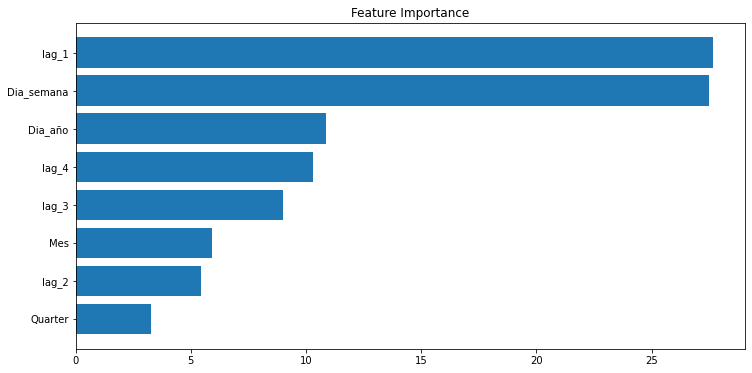

In [ ]:
feature_importance = m_b.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_X.columns)[sorted_idx])
plt.title('Feature Importance')

- Es notable que las variables con más importancia son los valores del día anterior (lag_1) y del día de la semana. Una relacion ya observada en la analise de la autocorrelacion.

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.5 MB/s eta 0:00:00


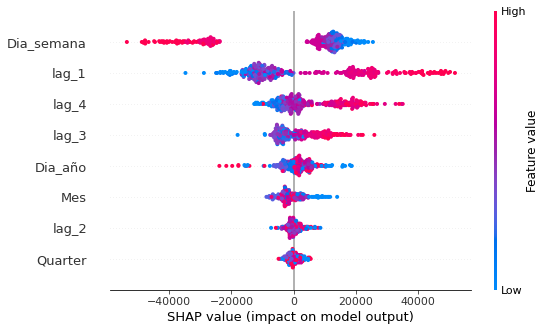

In [ ]:
import shap
explainer = shap.TreeExplainer(m_b)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)